# Team Bear: first pass on machine learning model

The goal of this notebook is to quantify the predictive power of GDP (per capita) data to determine if a given country has ever gotten a loan from the world bank.

Fore future reference let us record that the GDP data was extracted from the following source: [World Bank GDP per capita](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

Before diving into the model and its predictions, let us show first do a quick exploration of the raw data the World Bank provides, and how we pre-process it to make it more ammenable to Machine Learning methods.

We will store the raw gdp data in a pandas DataFrame named 'gdp_raw'

In [2]:
gdp_raw = pd.read_csv('gdp.csv', header = 2)
gdp_raw.drop(columns = 'Unnamed: 65', inplace = True)
gdp_raw.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,24985.013919,24712.493263,26441.619936,26893.011506,28396.908423,28452.170615,29350.805019,30253.279358,NaN,NaN
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,147.836769,147.238537,156.426780,182.521139,162.594548,180.489043,...,1686.695763,1672.363658,1653.188436,1658.650062,1507.800256,1404.953164,1540.232473,1534.171767,1485.307425,1330.140232
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.773234,59.860900,58.458009,78.706429,82.095307,101.108325,...,591.162798,641.871438,637.165464,613.856505,578.466353,509.220100,519.888913,493.756581,507.103392,508.808409
3,Africa Western and Central,AFW,GDP per capita (current US$),NY.GDP.PCAP.CD,107.963779,113.114697,118.865837,123.478967,131.892939,138.566819,...,1827.518347,1936.390962,2123.392433,2166.743309,1886.248158,1666.422406,1606.978332,1695.959215,1772.339155,1714.426800
4,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4615.468219,5100.097027,5254.881126,5408.411700,4166.979833,3506.073128,4095.810057,3289.643995,2809.626088,1895.770869


## Data Visualization - raw data

In order to be able to perform a better analysis of the GDP we would like to perform a dimensionality reduction to the GDP data. As a first step we want to understand the general trend the GDP follows, independent of the country. Part of the data of the gdp_raw data frame is that it contains a aggregate gdp per capita for the whole world -- we proceed by visualizing it.

In [3]:
from sklearn.linear_model import LinearRegression

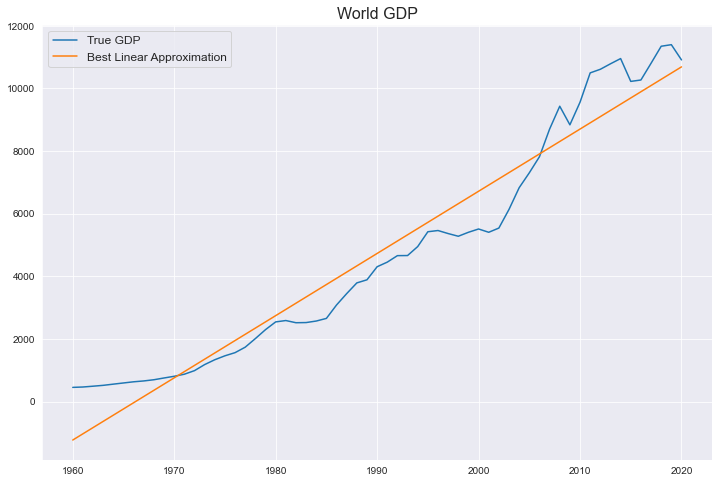

In [4]:
X_year = np.array([])
y_gdp = np.array([])
index_world = gdp_raw[gdp_raw.loc[:, 'Country Name']== 'World'].index
years = np.linspace(1960, 2020, num = 61, dtype = int)

for year in years:
# needs fixing, want to show the World GDP history. Country Name = 'World'
    if str(gdp_raw.loc[index_world, str(year)]) == 'nan':
        pass
    else:
        X_year = np.append(X_year, year)
        y_gdp = np.append(y_gdp, gdp_raw.loc[index_world, str(year)])
        
LR = LinearRegression()
LR.fit(X_year.reshape(-1,1), y_gdp)


plt.figure(figsize = (12,8))        
plt.plot(X_year, y_gdp, label = 'True GDP')
plt.plot(years.reshape(-1,1), LR.predict(years.reshape(-1,1)),  label = 'Best Linear Approximation')
plt.title('World GDP', fontsize = 16)
plt.legend(fontsize=12)

plt.show()

For this visualization we conclude that the World GDP follows a linear growth, and we find the best linear approximation using Linear Regression. This leads us to the first two features we extract from the GDP data: the slope and y-intercept of the best linear approximation.

But this is certainly not enough to encode all the complexity we find in the GDP -- even though, as we will see in later visualizations, this information already have some predictive power in determining if a certain country has ever gotten a loan. Therefore we develope a metric of GDP 'volatility' to encode some of the information lost in the linear regression. The GDP volatility can roughly be summarized as the root mean squared error from the linear regression (suitably normalized).

Let us facilitate the visualization of the GDP and linear regression of various countries with the following function.

In [5]:
years = np.linspace(1960, 2020, num = 61, dtype = int)

def get_gdp_visualization(sample):
    
    fig, axes = plt.subplots(int(sample/2), 2 , figsize = (12,12))
    ax = axes.ravel()
    
    i = 0
    for index in gdp_raw.sample(sample).index:
        X_year = np.array([])
        y_gdp = np.array([])
        #print(gdp_raw.loc[index, 'Country Name'])
        for year in years:
            if str(gdp_raw.loc[index, str(year)]) == 'nan':
                pass
            else:
                X_year = np.append(X_year, year)
                y_gdp = np.append(y_gdp, gdp_raw.loc[index, str(year)])
        
        if len(X_year)>0:
            lr = LinearRegression()
            lr.fit(X_year.reshape(-1,1), y_gdp) 
            
            ax[i].plot(X_year, y_gdp, label = 'True GDP')
            ax[i].plot(years.reshape(-1,1), lr.predict(years.reshape(-1,1)), label = 'Best Linear Approximation')
            ax[i].set_title(gdp_raw.loc[index, 'Country Name'], fontsize = 16)
            ax[i].legend(fontsize=12)
            i = i+1
        
    fig.tight_layout()

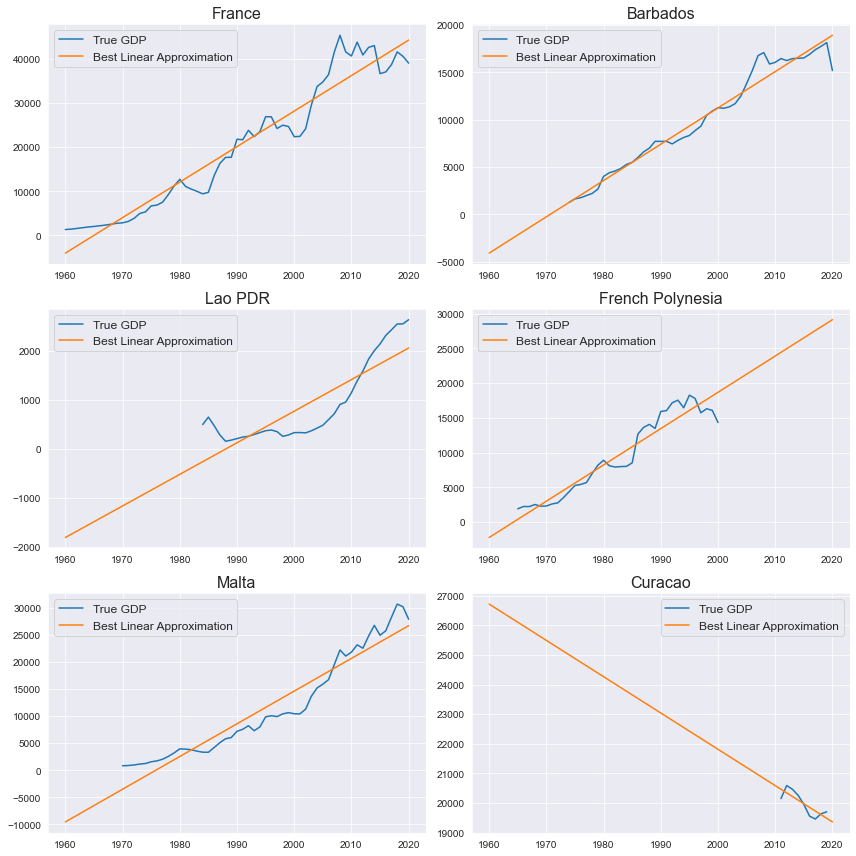

In [6]:
#Only works for a even number of samples
get_gdp_visualization(6)

## Data Visualization - preprocessed data

In this section we want to perform some visualizations on the refined data extrated from the gdp_raw data frame. The new refined data frame is stored as 'gdp_df' and it consists of the following features: slope, y_intercept, volatility, min_year, max_year, got_loan, and got_mentioned. Let us briefly explaine the meaning of these features.

- slope and y_intercept were extracted from the linear regression performed on the raw gdp data for each country. This was touched in more detail in the previous section.
- volatility roughly computes the root mean squared error from the linear regression -- however it is suitable scaled to take into account the vastly different scales of GDP various countries have.
- min_year and max_year are the minimum and maximum years for which we have the GDP for each country (earlierst being 1960, and latest being 2020).
- Finally, we have two possible classifiers 'got_loan' which determines if a country has ever gotten a loan from the world bank, and 'got_mentioned' which determines is a country has ever been mentioned in a world bank loan document. Ultimately we prefer to use 'got_loan' as it presents a better balanced classification (~ 55% of countries have gotten loans) as opposed to the highly unbalanced classification of 'got mentioned' (~ 85% of countries have been mentioned in loans).


In [7]:
gdp_df = pd.read_csv('gdp_analysis.csv')
X = gdp_df.loc[:,['slope', 'y_intercept', 'volatility', 'min_year', 'max_year']]
y = gdp_df.loc[:, 'got_loan']
#y = gdp_df.loc[:, 'got_mentioned']

In [8]:
print('Percentage of countries who got loans from the WorldBank:', 
      np.round(np.mean(gdp_df.got_loan.values),2))
print('Percentage of countries who got mentioned in WorldBank loan documents:', 
      np.round(np.mean(gdp_df.got_mentioned.values),2))

Percentage of countries who got loans from the WorldBank: 0.57
Percentage of countries who got mentioned in WorldBank loan documents: 0.83


In [9]:
gdp_df.head()

,country_name,slope,y_intercept,volatility,min_year,max_year,political_stability,got_loan,got_mentioned
0,afghanistan,7.675012,-1.497918e+04,0.540344,1960.0,2020.0,-2.479,0.0,0.0
1,albania,155.758189,-3.094915e+05,0.370373,1984.0,2020.0,-0.097,1.0,1.0
2,algeria,76.377837,-1.498252e+05,0.568859,1960.0,2020.0,-1.250,1.0,1.0
3,american samoa,228.691323,-4.494300e+05,0.597126,2002.0,2019.0,0.000,0.0,0.0
4,andorra,918.360834,-1.809247e+06,0.385188,1970.0,2019.0,1.349,0.0,0.0


As we can see from the next plot, most of the countries that have gotten loans from the World Bank seem to share a lot of common feaures when it comes to their GDP -- potentially showing some sort of bias in the way World Bank loans are distributed.

In particular, we want to emphasize the success that the volatility feature (developed as part of the project) seems to have for predicting if a country has gotten a world bank loan -- much more than the other measures extracted from the raw_gdp dataframe.

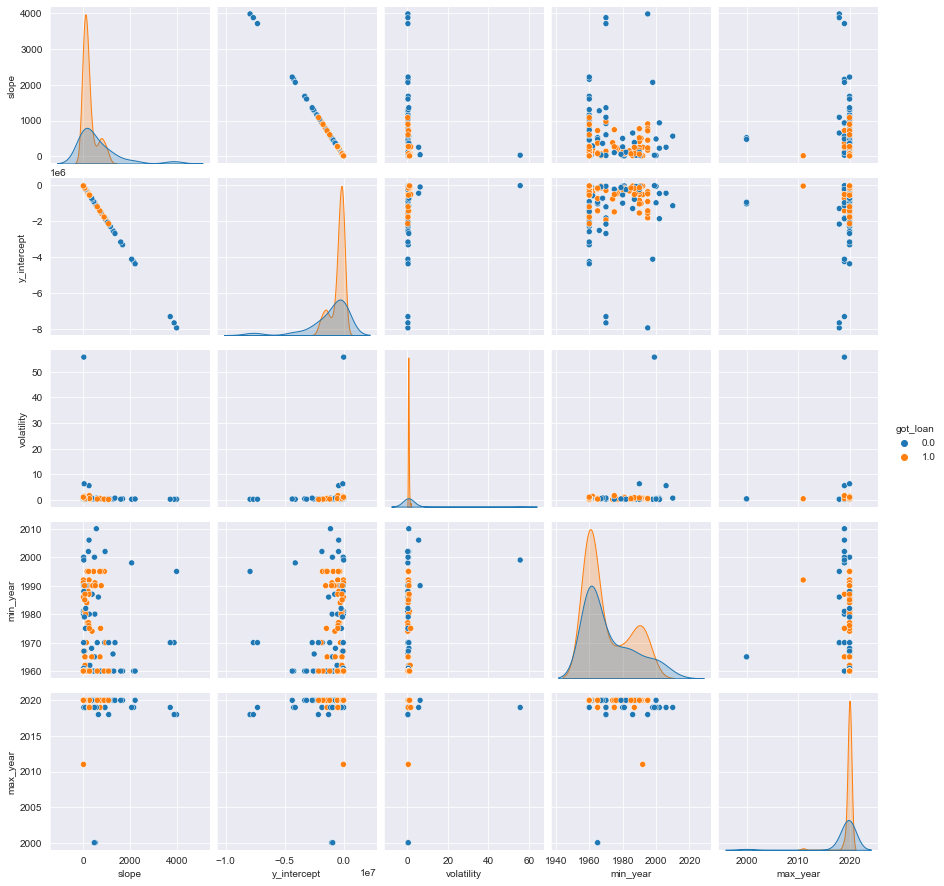

In [10]:
sns.pairplot(gdp_df, vars = ['slope', 'y_intercept', 'volatility', 'min_year', 'max_year'], hue = 'got_loan')

plt.show()

However, despite the apparent success of the volatility feature, we would like to advise caution when using these features since they still appear to be highly noisy. To illustrate the limitations of the features we plot some histogram diagrams below to show just how noisy the data still is.

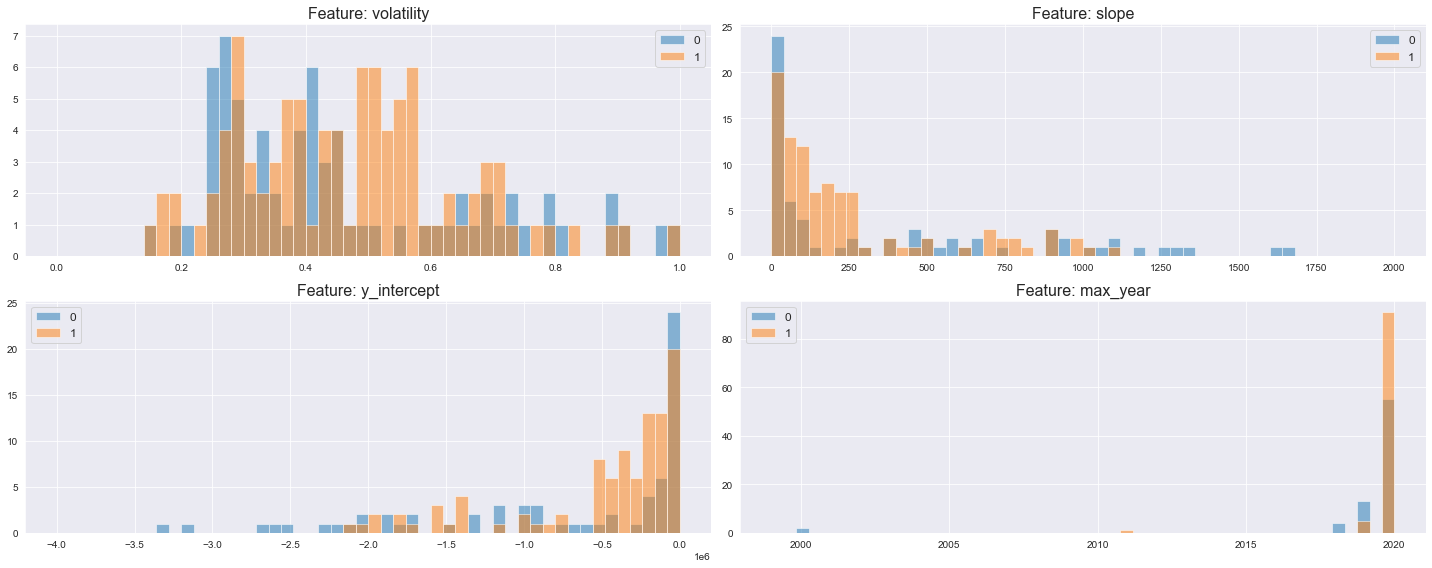

In [11]:
fig, axes = plt.subplots(2,2, figsize = (20,8))
ax = axes.ravel()

ax[0].hist(gdp_df[gdp_df.got_loan == 0.0].volatility, alpha = 0.5, range = (0,1), bins =50, label = '0')
ax[0].hist(gdp_df[gdp_df.got_loan == 1.0].volatility, alpha = 0.5,range = (0,1), bins = 50, label = '1')
ax[0].set_title('Feature: volatility', fontsize = 16)
ax[0].legend(fontsize=12)

ax[1].hist(gdp_df[gdp_df.got_loan == 0.0].slope, alpha = 0.5, range = (0,2000), bins = 50, label = '0')
ax[1].hist(gdp_df[gdp_df.got_loan == 1.0].slope, alpha = 0.5, range = (0,2000), bins = 50, label = '1')
ax[1].set_title('Feature: slope', fontsize = 16)
ax[1].legend(fontsize=12)

ax[2].hist(gdp_df[gdp_df.got_loan == 0.0].y_intercept, alpha = 0.5, range = (-4*(10**6),0), bins =50, label = '0')
ax[2].hist(gdp_df[gdp_df.got_loan == 1.0].y_intercept, alpha = 0.5,range = (-4*(10**6),0), bins = 50, label = '1')
ax[2].set_title('Feature: y_intercept', fontsize = 16)
ax[2].legend(fontsize=12)

ax[3].hist(gdp_df[gdp_df.got_loan == 0.0].max_year, alpha = 0.5, range = (1999,2020), bins = 50, label = '0')
ax[3].hist(gdp_df[gdp_df.got_loan == 1.0].max_year, alpha = 0.5, range = (1999,2020), bins = 50, label = '1')
ax[3].set_title('Feature: max_year', fontsize = 16)
ax[3].legend(fontsize=12)

fig.tight_layout()

## Machine Learning Models

Finally, we would like to actually quantify the predictive power of these features. Various classification models have been tested against the data set, but ultimately RandomForestsClassifier had the best performance -- after some hyperparameter tuning.


In [12]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.base import clone

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2, shuffle = True)

In [14]:
skf = StratifiedKFold(n_splits = 20)
cv = np.zeros((20,4))

rf = RandomForestClassifier(n_estimators = 60, max_depth = 4, criterion = 'gini', bootstrap = False)

i = 0
for train_index, val_index in skf.split(X_train, y_train):
    X_train_train = X_train.iloc[train_index]
    X_val = X_train.iloc[val_index]
    y_train_train = y_train.iloc[train_index]
    y_val = y_train.iloc[val_index]
    
    rf_clone = clone(rf)
    rf_clone.fit(X_train_train, y_train_train)
    
    cv[i, 0] = accuracy_score(y_val, rf_clone.predict(X_val))
    cv[i,1] = roc_auc_score(y_val, rf_clone.predict_proba(X_val)[:,1])
    
    cv[i,2] = accuracy_score(y_val, np.ones(len(y_val)))
    cv[i,3] = roc_auc_score(y_val, np.ones(len(y_val)))

    i = i + 1
    
cv_mean = np.mean(cv, axis = 0)

print('The following scores where computed agains the validation set.')
print('Mean accuracy score for Random Forest: ', np.round(cv_mean[0], 2))
print('Mean roc auc score for Random Forest: ', np.round(cv_mean[1],2))
print('Mean accuracy score for base model: ', np.round(cv_mean[2],2))
print('Mean roc auc score for base model: ', np.round(cv_mean[3],2))

The following scores where computed agains the validation set.
Mean accuracy score for Random Forest:  0.7
Mean roc auc score for Random Forest:  0.76
Mean accuracy score for base model:  0.57
Mean roc auc score for base model:  0.5


In [15]:
rf_test = RandomForestClassifier(n_estimators = 60, max_depth = 4, criterion = 'gini', bootstrap = False)
rf_test.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=4, n_estimators=60)

In [16]:
print('The following scores where computed agains the test set.')
print('Accuracy score for Random Forest: ', np.round(accuracy_score(y_test, rf_test.predict(X_test)), 2))
print('Roc auc score for Random Forest: ', np.round(roc_auc_score(y_test, rf_test.predict_proba(X_test)[:,1]), 2))

The following scores where computed agains the test set.
Accuracy score for Random Forest:  0.69
Roc auc score for Random Forest:  0.78


In [17]:
import keras
import tensorflow as tf
print(keras.__version__)

2.6.0


In [18]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils.np_utils import to_categorical

In [19]:
model1 = models.Sequential()
model1.add(layers.Dense(15, activation = 'relu', input_shape = (5,)))
model1.add(layers.Dense(10, activation = 'relu'))
model1.add(layers.Dense(2, activation = 'softmax'))

In [20]:
model1.compile(optimizer='rmsprop', 
                 loss='categorical_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.AUC()])

In [21]:
history1 = model1.fit(X_train, to_categorical(y_train),
           epochs = 40,
           validation_data = (X_test, to_categorical(y_test)) )

Epoch 1/40
5/5 [==============================] - 1s 49ms/step - loss: 122499.1094 - accuracy: 0.4338 - auc: 0.4338 - val_loss: 124492.0000 - val_accuracy: 0.4286 - val_auc: 0.4286
Epoch 2/40
5/5 [==============================] - 0s 4ms/step - loss: 100700.1953 - accuracy: 0.4338 - auc: 0.4338 - val_loss: 104649.7344 - val_accuracy: 0.4286 - val_auc: 0.4286
Epoch 3/40
5/5 [==============================] - 0s 4ms/step - loss: 85107.4609 - accuracy: 0.4338 - auc: 0.4338 - val_loss: 89402.9219 - val_accuracy: 0.4286 - val_auc: 0.4286
Epoch 4/40
5/5 [==============================] - 0s 4ms/step - loss: 73004.3203 - accuracy: 0.4338 - auc: 0.4338 - val_loss: 76641.4609 - val_accuracy: 0.4286 - val_auc: 0.4286
Epoch 5/40
5/5 [==============================] - 0s 4ms/step - loss: 62429.7188 - accuracy: 0.4338 - auc: 0.4338 - val_loss: 66347.0859 - val_accuracy: 0.4286 - val_auc: 0.4286
Epoch 6/40
5/5 [==============================] - 0s 4ms/step - loss: 53475.8867 - accuracy: 0.4338 - auc

In [22]:
history1_dict = history1.history

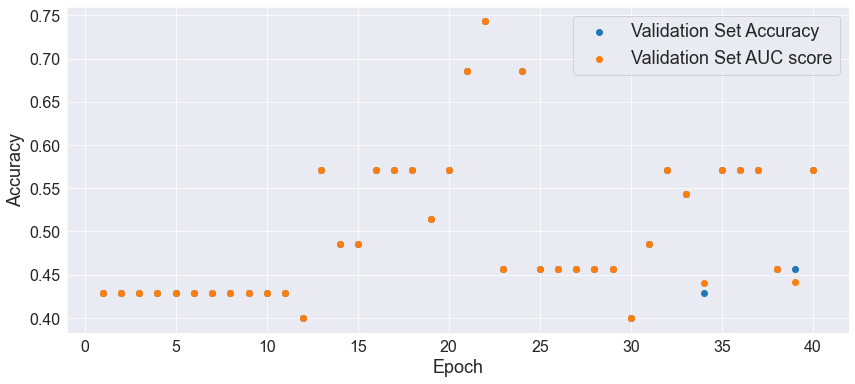

In [23]:
plt.figure(figsize = (14,6))

plt.scatter(range(1,41), history1_dict['val_accuracy'], label = "Validation Set Accuracy")
plt.scatter(range(1,41), history1_dict['val_auc'], label = "Validation Set AUC score")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()
